X_train.shape=(50000, 32, 32, 3), X_test.shape=(10000, 32, 32, 3)
y_train.shape=(50000,), y_test.shape=(10000,)


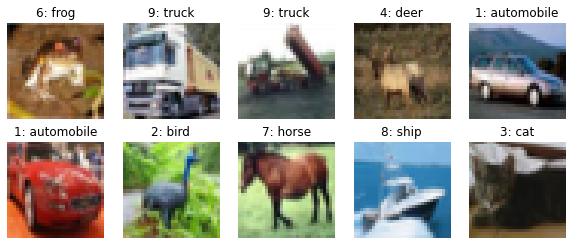

In [38]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()
print(f"{X_train.shape=}, {X_test.shape=}")
y_train, y_test = y_train.ravel(), y_test.ravel()
print(f"{y_train.shape=}, {y_test.shape=}")

labels = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"]

fig, axes = plt.subplots(2,5, figsize = (10,4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(f"{y_train[i]}: {labels[y_train[i]]}")
    ax.axis("off")


In [39]:
scaled_X_train = X_train.astype("float32")/255
scaled_X_test = X_test.astype("float32")/255

CNN model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate = .001, drop_rate = .5, kernels = [32,64]):
    adam = Adam(learning_rate = learning_rate)

    model = Sequential(name = "CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3,3), 
            activation = "relu", kernel_initializer = "he_normal", 
            input_shape = X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

    #MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model()
model.summary()


Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2304)              0 

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_loss", mode ="min", patience = 5)

model.fit(
    scaled_X_train,
    y_train,
    epochs = 100,
    callbacks = [early_stopper],
    validation_split = 1/5
)

Epoch 1/100
250/250 [==============================] - 6s 21ms/step - loss: 2.3293 - acc: 0.0945 - val_loss: 2.3031 - val_acc: 0.0915
Epoch 2/100
250/250 [==============================] - 5s 20ms/step - loss: 2.3011 - acc: 0.1138 - val_loss: 2.3066 - val_acc: 0.0995
Epoch 3/100
250/250 [==============================] - 5s 20ms/step - loss: 2.2947 - acc: 0.1240 - val_loss: 2.3066 - val_acc: 0.0990
Epoch 4/100
250/250 [==============================] - 5s 21ms/step - loss: 2.2820 - acc: 0.1343 - val_loss: 2.3213 - val_acc: 0.0970
Epoch 5/100
250/250 [==============================] - 5s 21ms/step - loss: 2.2591 - acc: 0.1479 - val_loss: 2.3350 - val_acc: 0.0920
Epoch 6/100
250/250 [==============================] - 5s 20ms/step - loss: 2.2300 - acc: 0.1622 - val_loss: 2.3616 - val_acc: 0.0890


In [42]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2,figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[0], grid = True)

In [43]:
metrics = pd.DataFrame(model.history.history)


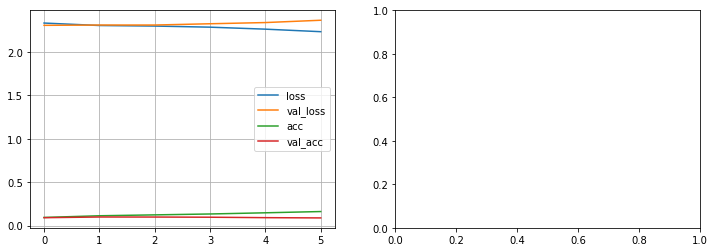

In [44]:
plot_metrics(metrics)

In [45]:
def evaluate_model(**kwargs):
    model = CNN_model(**kwargs)
    model.fit(
        scaled_X_train,
        y_train,
        validation_split = 1/5,
        epochs = 6,
    )

    metrics = pd.DataFrame(model.history.history)
    val_acc = metrics["val_acc"].iloc[-1]
    return val_acc



In [46]:
dropout_acc = {}

for drop_rate in np.arange(.1, .6, .1):
    drop_rate = np.round(drop_rate, 1)
    dropout_acc[drop_rate] = evaluate_model(drop_rate=drop_rate)


Epoch 1/6
250/250 [==============================] - 6s 21ms/step - loss: 2.3239 - acc: 0.0983 - val_loss: 2.3065 - val_acc: 0.1040
Epoch 2/6
250/250 [==============================] - 5s 20ms/step - loss: 2.2987 - acc: 0.1251 - val_loss: 2.3112 - val_acc: 0.1080
Epoch 3/6
250/250 [==============================] - 5s 21ms/step - loss: 2.2740 - acc: 0.1447 - val_loss: 2.3258 - val_acc: 0.1020
Epoch 4/6
250/250 [==============================] - 5s 20ms/step - loss: 2.2233 - acc: 0.1741 - val_loss: 2.3732 - val_acc: 0.1060
Epoch 5/6
250/250 [==============================] - 5s 20ms/step - loss: 2.1245 - acc: 0.2167 - val_loss: 2.5019 - val_acc: 0.0990
Epoch 6/6
250/250 [==============================] - 5s 19ms/step - loss: 1.9483 - acc: 0.2994 - val_loss: 2.5732 - val_acc: 0.0955
Epoch 1/6
250/250 [==============================] - 6s 22ms/step - loss: 2.3180 - acc: 0.1094 - val_loss: 2.3029 - val_acc: 0.0995
Epoch 2/6
250/250 [==============================] - 5s 21ms/step - loss: 2.

<AxesSubplot:xlabel='Dropouts', ylabel='Validation acc'>

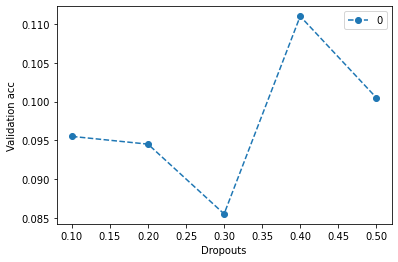

In [47]:
pd.DataFrame(dropout_acc.values(), index=dropout_acc.keys()).plot(xlabel = "Dropouts", 
ylabel = "Validation acc", style = "--o")